## Install

In [1]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.2.1 --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 2.2.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.2.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.2.1 which is incompatible.
torchvision 0.16.0+cu121 requires torch==2.1.0, but you have torch 2.2.1 which is incompatible.


In [2]:
import torch

torch.__version__

'2.2.1+cu121'

## Tensors

In [3]:
scalar = torch.tensor(42)
scalar

tensor(42)

In [4]:
scalar.item()

42

In [5]:
scalar.dtype

torch.int64

In [6]:
float_scalar = scalar.to(torch.float32)
float_scalar, float_scalar.dtype

(tensor(42.), torch.float32)

In [7]:
vector = torch.tensor([1, 42])
vector

tensor([ 1, 42])

In [8]:
vector.shape

torch.Size([2])

In [9]:
matrix = torch.tensor([[1, 42], [42, 1]])
matrix

tensor([[ 1, 42],
        [42,  1]])

## Operations

In [10]:
torch.zeros((2, 2))

tensor([[0., 0.],
        [0., 0.]])

In [11]:
random_tensor = torch.rand(size=(2, 3))
random_tensor

tensor([[0.0201, 0.2397, 0.1471],
        [0.8579, 0.2016, 0.1124]])

In [12]:
t = torch.tensor([[1, 2, 3], [4, 5, 6]])
t.reshape(3, 2)

tensor([[1, 2],
        [3, 4],
        [5, 6]])

In [13]:
t = torch.tensor([[1, 42], [42, 1]])
print(t.shape)
torch.unsqueeze(t, dim=0).shape

torch.Size([2, 2])


torch.Size([1, 2, 2])

In [14]:
t = torch.tensor([[0.3, 0.5, 0.2], [0.1, 0.05, 0.85]])
t.max()

tensor(0.8500)

In [15]:
t.max(dim=1)

torch.return_types.max(
values=tensor([0.5000, 0.8500]),
indices=tensor([1, 2]))

## Creating Tensors in the real-world

In [16]:
import numpy as np

a = np.array([1, 42])
t = torch.from_numpy(a)
t

tensor([ 1, 42])

In [17]:
import pandas as pd

df = pd.DataFrame({"numbers": [1, 42]})
df

,numbers
0,1
1,42


In [18]:
t = torch.tensor(df.numbers.to_numpy())
t

tensor([ 1, 42])

## Running on GPU

In [19]:
torch.cuda.is_available()

True

In [20]:
!nvidia-smi --query-gpu=memory.used --format=csv

memory.used [MiB]
3 MiB


In [21]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [22]:
gpu_tensor = torch.tensor([1, 42], device=device)
gpu_tensor

tensor([ 1, 42], device='cuda:0')

In [23]:
!nvidia-smi --query-gpu=memory.used --format=csv

memory.used [MiB]
105 MiB


In [24]:
cpu_tensor = torch.tensor([1, 42])
print(cpu_tensor.device)
print(cpu_tensor.to(device).device)

cpu
cuda:0


In [25]:
cpu_tensor = torch.tensor([1, 42])
gpu_tensor = torch.tensor([1, 42], device=device)

try:
    cpu_tensor * gpu_tensor
except Exception as e:
    print("Error:", e)

Error: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!


In [26]:
cpu_tensor.to(device) * gpu_tensor

tensor([   1, 1764], device='cuda:0')

## Data Wrangling

In [27]:
import copy
import random
import re
from collections import OrderedDict
from typing import List, Optional, Tuple

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pylab import rcParams
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}

mpl.rcParams.update(MY_STYLE)

SEED = 42


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(SEED)

In [28]:
!gdown -q 1cxkAwCWY9w7Uhz19ypOH8jW3s_rro_gw

In [29]:
df = pd.read_csv("fitbit-daily-activity.csv")
df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [30]:
pattern = re.compile(r"(?<!^)(?=[A-Z])")
column_names = [pattern.sub("_", name).lower() for name in df.columns]
df.columns = column_names
df.head()

,id,activity_date,total_steps,total_distance,tracker_distance,logged_activities_distance,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [31]:
df.isnull().values.any()

False

In [32]:
user_ids = df.groupby("id").apply(lambda df: df.sample(1)).reset_index(drop=True).id
np.random.seed(42)
shuffled_ids = np.random.permutation(user_ids)

In [33]:
train_ids, temp_ids = train_test_split(shuffled_ids, test_size=0.2, random_state=42)
test_ids, val_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

train_df = df[df["id"].isin(train_ids)]
val_df = df[df["id"].isin(val_ids)]
test_df = df[df["id"].isin(test_ids)]

len(train_df), len(val_df), len(test_df)

(724, 124, 92)

In [34]:
train_df.head()

,id,activity_date,total_steps,total_distance,tracker_distance,logged_activities_distance,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,calories
31,1624580081,4/12/2016,8163,5.31,5.31,0.0,0.0,0.0,5.31,0.00,0,0,146,1294,1432
32,1624580081,4/13/2016,7007,4.55,4.55,0.0,0.0,0.0,4.55,0.00,0,0,148,1292,1411
33,1624580081,4/14/2016,9107,5.92,5.92,0.0,0.0,0.0,5.91,0.01,0,0,236,1204,1572
34,1624580081,4/15/2016,1510,0.98,0.98,0.0,0.0,0.0,0.97,0.00,0,0,96,1344,1344
35,1624580081,4/16/2016,5370,3.49,3.49,0.0,0.0,0.0,3.49,0.00,0,0,176,1264,1463


In [35]:
class CaloriesDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.features = data[["total_distance", "very_active_minutes"]]
        self.labels = data["calories"]

    def __getitem__(self, index):
        features = torch.FloatTensor(self.features.iloc[index].to_numpy())
        label = self.labels.iloc[index]
        return features, label

    def __len__(self):
        return len(self.labels)

In [36]:
train_dataset = CaloriesDataset(train_df)
val_dataset = CaloriesDataset(val_df)
test_dataset = CaloriesDataset(test_df)
train_dataset[0]

(tensor([5.3100, 0.0000]), 1432)

In [37]:
train_loader = DataLoader(
    dataset=train_dataset, batch_size=8, shuffle=True, num_workers=1, drop_last=True
)

val_loader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=False, num_workers=1)

test_loader = DataLoader(
    dataset=test_dataset, batch_size=8, shuffle=False, num_workers=1
)

In [38]:
for batch_idx, (features, labels) in enumerate(train_loader):
    print(features)
    print(labels)
    break

tensor([[ 9.6900,  0.0000],
        [ 8.4800, 50.0000],
        [ 3.6200,  1.0000],
        [ 7.8800, 14.0000],
        [ 6.2300,  0.0000],
        [ 0.0000,  0.0000],
        [ 5.6800,  5.0000],
        [11.1200, 61.0000]])
tensor([3266, 1570, 1882, 2885, 2044, 1841, 1830, 2324])


## Model

In [39]:
model = nn.Sequential(
    OrderedDict(
        [
            ("hidden_layer_1", nn.Linear(2, 64)),
            ("activation_1", nn.ReLU()),
            ("hidden_layer_2", nn.Linear(64, 32)),
            ("activation_2", nn.ReLU()),
            ("output_layer", nn.Linear(32, 1)),
        ]
    )
)
model

Sequential(
  (hidden_layer_1): Linear(in_features=2, out_features=64, bias=True)
  (activation_1): ReLU()
  (hidden_layer_2): Linear(in_features=64, out_features=32, bias=True)
  (activation_2): ReLU()
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [40]:
model.hidden_layer_1.weight[:10]

tensor([[-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188],
        [ 0.6146,  0.1323],
        [ 0.5224,  0.0958],
        [ 0.3410, -0.0998],
        [ 0.5451,  0.1045],
        [-0.3301,  0.1802],
        [-0.3258, -0.0829],
        [-0.2872,  0.4691]], grad_fn=<SliceBackward0>)

In [41]:
layers = []

for name, child in model.named_children():
    if "activation" in name:
        continue
    layers.append(
        {
            "layer": name,
            "weight_parameters": child.weight.numel(),
            "bias_parameters": child.bias.numel(),
        }
    )

pd.DataFrame(layers)

,layer,weight_parameters,bias_parameters
0,hidden_layer_1,128,64
1,hidden_layer_2,2048,32
2,output_layer,32,1


In [42]:
for batch_idx, (features, labels) in enumerate(train_loader):
    predictions = model(features)
    break
predictions

tensor([[-1.6218],
        [-0.3313],
        [-2.9512],
        [-0.5871],
        [-0.0830],
        [-0.5277],
        [-0.9640],
        [-6.7983]], grad_fn=<AddmmBackward0>)

## Training

In [43]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    train_loss_accum = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(features)
        logits = torch.squeeze(logits)
        labels = labels.float()
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss_accum += loss.item() * features.size(0)
    return train_loss_accum / len(train_loader.dataset)


def validate(model, val_loader, loss_fn, device):
    model.eval()
    val_loss_accum = 0.0
    with torch.inference_mode():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            logits = model(features)
            logits = torch.squeeze(logits)
            labels = labels.float()
            loss = loss_fn(logits, labels)
            val_loss_accum += loss.item() * features.size(0)
    return val_loss_accum / len(val_loader.dataset)

In [44]:
loss_fn = nn.HuberLoss(delta=0.6)
optimizer = Adam(model.parameters(), lr=0.001)
N_EPOCHS = 100
best_val_loss = float("inf")
best_model_state = copy.deepcopy(model.state_dict())
train_losses = []
val_losses = []
model = model.to(device)

for epoch in tqdm(range(N_EPOCHS)):
    train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss = validate(model, val_loader, loss_fn, device)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())

    train_losses.append(train_loss)
    val_losses.append(val_loss)

100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


## Evaluation

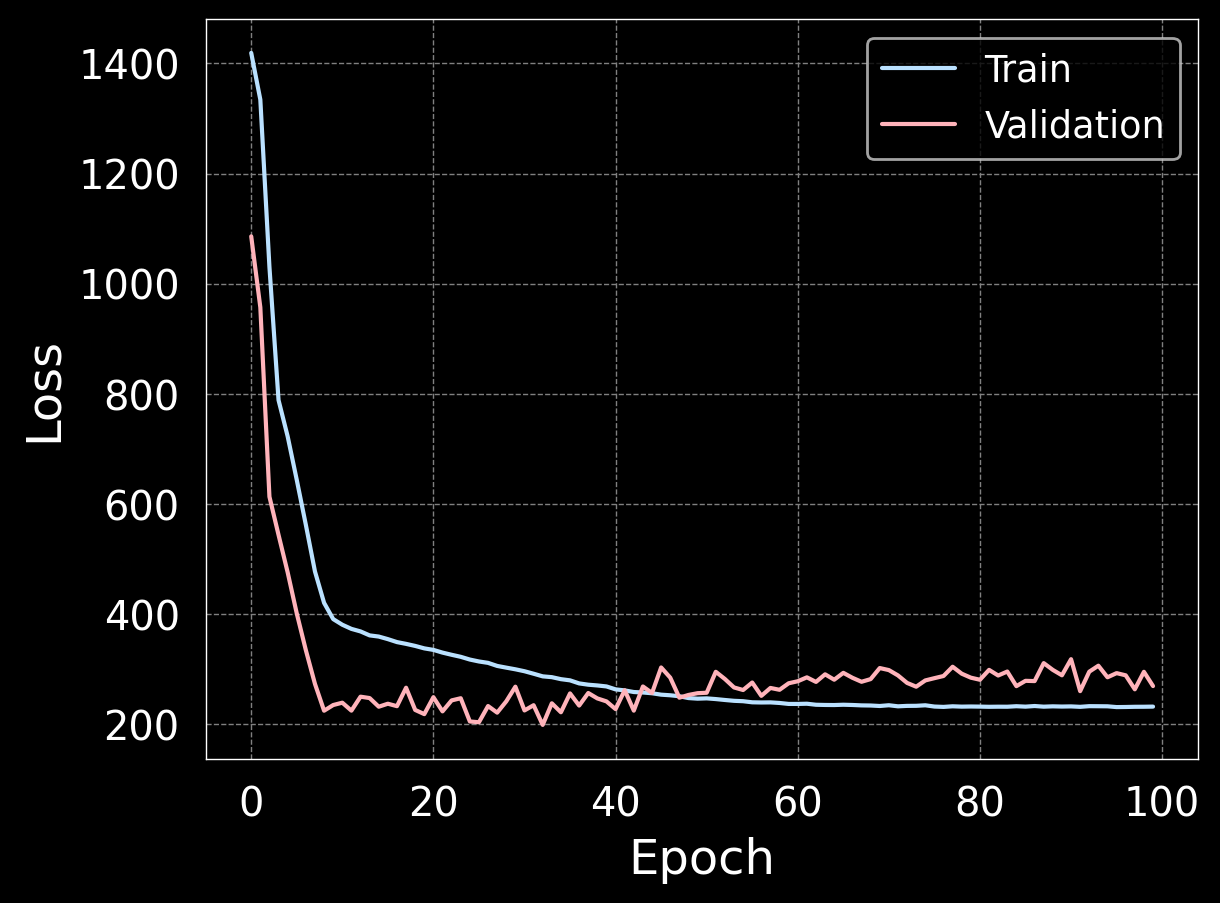

In [45]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();

In [46]:
min(val_losses), val_losses[-1]

(199.0787850656817, 269.5737073344569)

In [47]:
best_model = copy.deepcopy(model)
best_model.load_state_dict(best_model_state)

<All keys matched successfully>

In [48]:
best_model.eval()
predictions = []
labels = []
with torch.inference_mode():
    for features, batch_labels in tqdm(test_loader):
        predictions.append(best_model(features.to(device)))
        labels.append(batch_labels)

100%|██████████| 12/12 [00:00<00:00, 77.46it/s]


In [49]:
predictions[0]

tensor([[2948.9766],
        [1835.0200],
        [2935.4951],
        [1930.4349],
        [2719.3728],
        [1956.1665],
        [1967.2430],
        [2975.8218]], device='cuda:0')

In [50]:
labels = torch.cat(labels).flatten().tolist()

In [51]:
predictions = torch.cat(predictions).flatten().tolist()

In [52]:
len(labels), len(predictions)

(92, 92)

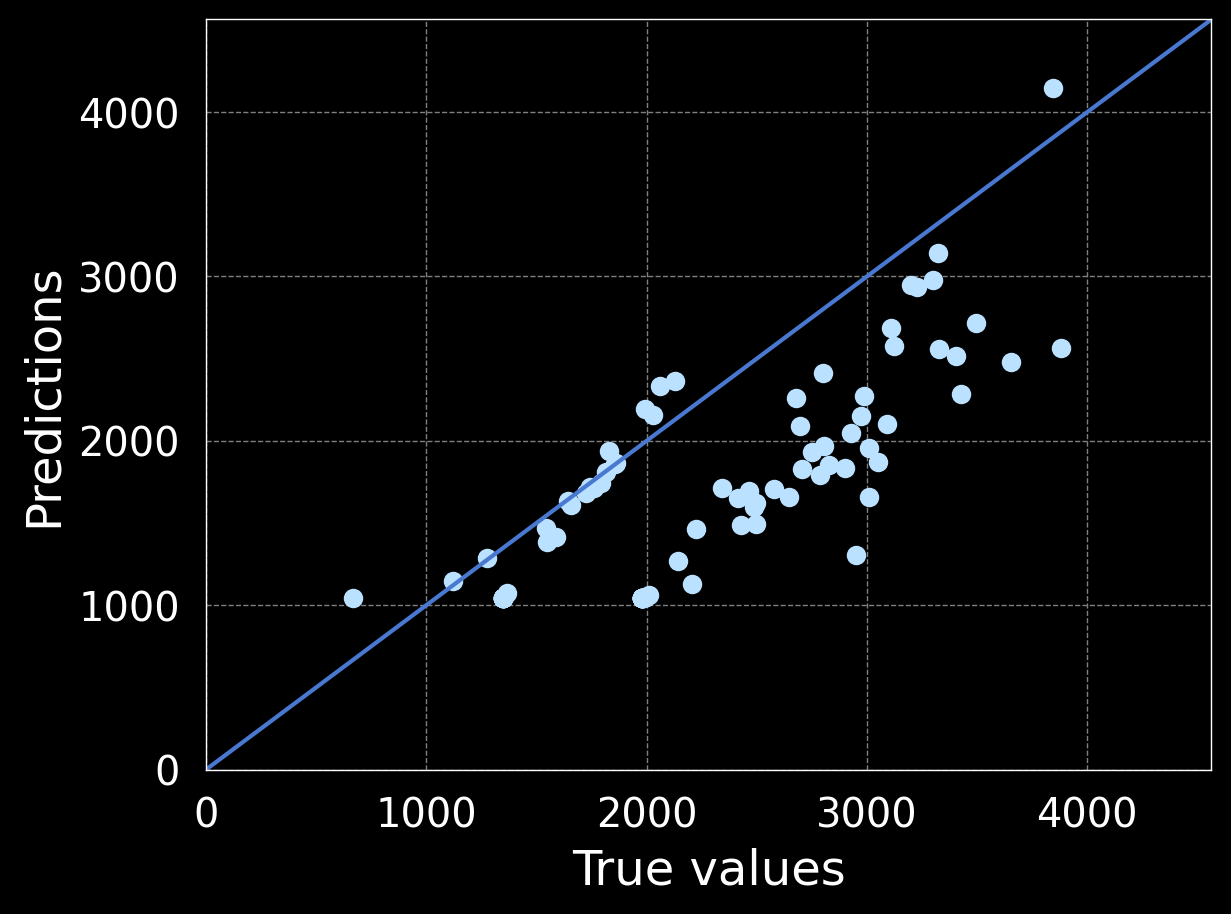

In [53]:
plt.scatter(labels, predictions)

max_lim = max(max(predictions), max(labels))
max_lim += max_lim * 0.1

plt.xlim(0, max_lim)
plt.ylim(0, max_lim)

plt.plot([0, max_lim], [0, max_lim], "b-")

plt.xlabel("True values")
plt.ylabel("Predictions")
plt.tight_layout();